# Application of topic modelling with SE articles and SE Glossary articles for the labelling of OECD's Glossary articles



In [1]:
import gensim
import pandas as pd
import numpy as np

import re

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt

%matplotlib inline

import pyodbc

### Glossary articles  

* Definitions from dat_glossary.
* Titles from dat_link_info (with resource_information_id=1, i.e. Eurostat, see ESTAT.V1.mod_resource_information).
* Match above on id.


In [2]:
c = pyodbc.connect('DSN=Virtuoso All;DBA=ESTAT;UID=xxxx;PWD=xxxx')
cursor = c.cursor()

SQLCommand = """SELECT T1.id, T1.definition, T2.title 
                FROM ESTAT.V1.dat_glossary as T1 
                INNER JOIN ESTAT.V1.dat_link_info as T2  
                  ON T1.id=T2.id 
                WHERE T2.resource_information_id=1 """

GL_df = pd.read_sql(SQLCommand,c)
GL_df = GL_df[['id', 'title', 'definition']]

GL_df


,id,title,definition
0,1,Accident at work,An accident at work in the framework ...
1,5,Fatal accident at work,A fatal accident at work refers to an...
2,6,Non-fatal accident at work,A non-fatal accident at work is...
3,8,Aggregate demand,Aggregate demand is the total amount of ...
4,9,Goods and services account,The goods and services account shows ...
...,...,...,...
1309,2319,Actual individual consumption (AIC),"Actual individual consumption , abbrevia..."
1310,2321,Activity rate,Activity rate is the percentage of a...
1311,2322,Activation policies,The activation policies are policies ...
1312,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a fe..."


### Delete records with empty definitions and carry out data cleansing


In [3]:
## drop records with any field empty
GL_df = GL_df.dropna(axis=0,how='any')
print(GL_df.isnull().sum())
GL_df.reset_index(drop=True, inplace=True)

import re
#import unicodedata as ud

def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    x = re.sub(r'â.{2}',"'",x) ### !!! NEW: single quotes are read as: âXX
    
    #x = x.encode('latin1').decode('utf-8') ## â\x80\x99
    #x = ud.normalize('NFKD',x).encode('ascii', 'ignore').decode()
    
    return x


GL_df['title'] = GL_df['title'].apply(clean)
GL_df['title'] = GL_df['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
GL_df['definition'] = GL_df['definition'].apply(clean)

GL_df.head(5)

id            0
title         0
definition    0
dtype: int64


,id,title,definition
0,1,Accident at work,An accident at work in the framework of the ad...
1,5,Fatal accident at work,A fatal accident at work refers to an accident...
2,6,Non-fatal accident at work,A non-fatal accident at work is an accident wh...
3,8,Aggregate demand,Aggregate demand is the total amount of goods ...
4,9,Goods and services account,The goods and services account shows the balan...


### Delete "special" records

* i.e. redirections.



In [4]:
## Drop The records with definitions "The revision ..." and "Redirect to ..." 

idx = GL_df[GL_df['definition'].str.startswith('The revision #')].index
print(idx)
GL_df.drop(idx , inplace=True)
idx = GL_df[GL_df['definition'].str.startswith('Redirect to')].index
print(idx)
GL_df.drop(idx , inplace=True)
GL_df.reset_index(drop=True, inplace=True)
GL_df

Int64Index([ 230,  292,  384,  386,  433,  436,  438,  439,  504,  519,  530,
             557,  588,  729,  742,  775,  826,  889,  891,  912,  960,  961,
             969, 1003, 1007, 1133, 1144, 1182, 1231],
           dtype='int64')
Int64Index([], dtype='int64')


,id,title,definition
0,1,Accident at work,An accident at work in the framework of the ad...
1,5,Fatal accident at work,A fatal accident at work refers to an accident...
2,6,Non-fatal accident at work,A non-fatal accident at work is an accident wh...
3,8,Aggregate demand,Aggregate demand is the total amount of goods ...
4,9,Goods and services account,The goods and services account shows the balan...
...,...,...,...
1280,2319,Actual individual consumption (AIC),"Actual individual consumption, abbreviated as ..."
1281,2321,Activity rate,Activity rate is the percentage of active pers...
1282,2322,Activation policies,The activation policies are policies designed ...
1283,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a few ..."


### Create column "raw content" with the titles and the definitions

In [5]:
GL_df['raw content'] = GL_df['title'] +'. '+GL_df['definition']
GL_df['source'] = 'GL'
GL_df

,id,title,definition,raw content,source
0,1,Accident at work,An accident at work in the framework of the ad...,Accident at work. An accident at work in the f...,GL
1,5,Fatal accident at work,A fatal accident at work refers to an accident...,Fatal accident at work. A fatal accident at wo...,GL
2,6,Non-fatal accident at work,A non-fatal accident at work is an accident wh...,Non-fatal accident at work. A non-fatal accide...,GL
3,8,Aggregate demand,Aggregate demand is the total amount of goods ...,Aggregate demand. Aggregate demand is the tota...,GL
4,9,Goods and services account,The goods and services account shows the balan...,Goods and services account. The goods and serv...,GL
...,...,...,...,...,...
1280,2319,Actual individual consumption (AIC),"Actual individual consumption, abbreviated as ...",Actual individual consumption (AIC). Actual in...,GL
1281,2321,Activity rate,Activity rate is the percentage of active pers...,Activity rate. Activity rate is the percentage...,GL
1282,2322,Activation policies,The activation policies are policies designed ...,Activation policies. The activation policies a...,GL
1283,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a few ...",Active enterprises - FRIBS. <Brief user-orient...,GL


### Statistics Explained articles

* IDs, titles from dat_link_info, with resource_information_id=1, i.e. Eurostat (see ESTAT.V1.mod_resource_information) and matching IDs from dat_article.
* Carry out data cleansing on titles.

In [6]:
SQLCommand = """SELECT id, title 
                FROM ESTAT.V1.dat_link_info 
                WHERE resource_information_id=1 AND id IN (SELECT id FROM ESTAT.V1.dat_article) """

SE_df = pd.read_sql(SQLCommand,c)

SE_df['title'] = SE_df['title'].apply(clean)
SE_df.head(5)

,id,title
0,7,Accidents at work statistics
1,13,National accounts and GDP
2,16,Railway safety statistics in the EU
3,17,Railway freight transport statistics
4,18,Railway passenger transport statistics - quart...


### Add paragraphs titles and contents

* From dat_article_paragraph with abstract=0 (i.e. "no").
* Match article_id from dat_article_paragraph with id from dat_article.
* Carry out data cleansing on titles and paragraph contents.

In [7]:
SQLCommand = """SELECT article_id, title, content 
                FROM ESTAT.V1.dat_article_paragraph
                WHERE abstract=0 AND article_id IN (SELECT id FROM ESTAT.V1.dat_article) """

add_content = pd.read_sql(SQLCommand,c)
add_content['title'] = add_content['title'].apply(clean)
add_content['content'] = add_content['content'].apply(clean)
add_content

,article_id,title,content
0,2905,Absences from work sharply increase in first h...,Absences from work recorded unprecedented high...
1,2905,Absences: 9.5 % of employment in Q4 2019 and 1...,The article's next figure (Figure 4) compares ...
2,2905,Higher share of absences from work among women...,"Considering all four quarters of 2020, the sha..."
3,2905,Absences from work due to own illness or disab...,"From Q4 2019 to Q4 2020, the number of people ..."
4,2905,Absences from work due to holidays,"Expressed as a share of employed people, absen..."
...,...,...,...
3854,10539,General presentation and definition,Scope of asylum statistics and Dublin statisti...
3855,10539,Methodological aspects in asylum statistics,Annual aggregate of the number of asylum appli...
3856,10539,Methodological aspects in Dublin statistics,Asymmetries For most of the collected Dublin s...
3857,10539,What questions can or cannot be answered with ...,How many asylum seekers are entering EU Member...


### Aggregate above paragraph titles and contents  from SE articles paragraphs by article id

* Create a column _raw content_ which gathers all paragraph titles and contents in one text per article.

In [8]:
add_content_grouped = add_content.groupby(['article_id'])[['title','content']].aggregate(lambda x: list(x))
add_content_grouped.reset_index(drop=False, inplace=True)
for i in range(len(add_content_grouped)):
    add_content_grouped.loc[i,'raw content'] = ''
    for (a,b) in zip(add_content_grouped.loc[i,'title'],add_content_grouped.loc[i,'content']):
        add_content_grouped.loc[i,'raw content'] += ' '+a + ' ' + b
add_content_grouped = add_content_grouped[['article_id','raw content']]    

add_content_grouped

,article_id,raw content
0,7,"Number of accidents In 2018, there were 3.1 m..."
1,13,Developments for GDP in the EU-27: growth sin...
2,16,Fall in the number of railway accidents 9 % f...
3,17,Downturn for EU transport performance in 2019...
4,18,Rail passenger transport performance continue...
...,...,...
860,10456,Problem After successfully identifying and jo...
861,10470,"Problem In France, there was significant room..."
862,10506,General overview Nine PEEIs concern short-ter...
863,10531,What are administrative sources? The term 'ad...


### Merge raw content of SE articles with main file

* Add the title to column "raw content".

In [9]:
SE_df = pd.merge(SE_df,add_content_grouped,left_on='id',right_on='article_id',how='inner')
SE_df.drop(['article_id'],axis=1,inplace=True)

SE_df['raw content'] = SE_df['title'] +'. ' + SE_df['raw content']
SE_df['source'] = 'SE'

SE_df.head(5)

,id,title,raw content,source
0,7,Accidents at work statistics,Accidents at work statistics. Number of accid...,SE
1,13,National accounts and GDP,National accounts and GDP. Developments for G...,SE
2,16,Railway safety statistics in the EU,Railway safety statistics in the EU. Fall in ...,SE
3,17,Railway freight transport statistics,Railway freight transport statistics. Downtur...,SE
4,18,Railway passenger transport statistics - quart...,Railway passenger transport statistics - quart...,SE


### Concatenate the two dataframes keeping the "source" variable

In [10]:
all_df = pd.concat([GL_df[['id','source','title','raw content']],SE_df[['id','source','title','raw content']]],ignore_index=True)
all_df

,id,source,title,raw content
0,1,GL,Accident at work,Accident at work. An accident at work in the f...
1,5,GL,Fatal accident at work,Fatal accident at work. A fatal accident at wo...
2,6,GL,Non-fatal accident at work,Non-fatal accident at work. A non-fatal accide...
3,8,GL,Aggregate demand,Aggregate demand. Aggregate demand is the tota...
4,9,GL,Goods and services account,Goods and services account. The goods and serv...
...,...,...,...,...
2145,10456,SE,"Merging statistics and geospatial information,...","Merging statistics and geospatial information,..."
2146,10470,SE,"Merging statistics and geospatial information,...","Merging statistics and geospatial information,..."
2147,10506,SE,Methods for compiling PEEIs in short-term busi...,Methods for compiling PEEIs in short-term busi...
2148,10531,SE,Building the System of National Accounts - adm...,Building the System of National Accounts - adm...


### Pre-process the input data


Next we define a function _sent_to_words_ which accepts a series of texts and:
* Converts everything to lowercase and drops accents, 
* Deletes stop words, 
* Tokenizes the texts, 
* Applιes Porter's stemmer and keeps as final tokens the resulting terms with minimum length 5. 

We call this function with the articles "raw content" column. The result, _texts_ is a nested list with 2150 outer elements corresponding to all articles. The inner lists contain the tokens for each text.

In [11]:
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS

all_stopwords_gensim = STOPWORDS

def sent_to_words(sentences):
    p = PorterStemmer()
    for sentence in sentences:
        sentence = str(gensim.utils.simple_preprocess(sentence, deacc=True))
        tokens = gensim.utils.tokenize(sentence)
        
        ##minimum length = 5 
        sentence = [p.stem(token) for token in tokens if len(p.stem(token)) >= 5 and not token in all_stopwords_gensim] 
        
        yield(sentence)
                
texts = list(sent_to_words(all_df['raw content']))
print('\nFirst 5 texts: \n',texts[:5])
print('\nTotal texts: ',len(texts),'\n')



First 5 texts: 
 [['accid', 'accid', 'framework', 'administr', 'collect', 'european', 'statist', 'accid', 'discret', 'occurr', 'cours', 'physic', 'mental', 'phrase', 'cours', 'whilst', 'engag', 'occup', 'activ', 'spent', 'includ', 'traffic', 'accid', 'cours', 'exclud', 'accid', 'journei', 'workplac', 'definit', 'accid', 'modul', 'accid', 'relat', 'health', 'problem', 'labour', 'survei', 'principl', 'except', 'accid', 'mental', 'exclud', 'difficult', 'distinguish', 'relev', 'relat', 'health', 'problem', 'follow', 'accid', 'cover', 'respect', 'definit', 'includ', 'poison', 'person', 'accid', 'occur', 'premis', 'employ', 'emploi', 'victim', 'includ', 'accid', 'attend', 'cours', 'provid', 'servic', 'premis', 'employ', 'visit', 'purpos', 'cours', 'victim', 'accid', 'occur', 'visit', 'locat', 'outsid', 'premis', 'employ', 'employe', 'normal', 'accid', 'regular', 'break', 'includ', 'lunch', 'place', 'organis', 'employ', 'accid', 'deliveri', 'custom', 'premis', 'compani', 'public', 'administr

### Creation of corpus and terms frequencies

The next steps are:
* Create a vocabulary from _texts_ with name _id2word_. This is a dictionary with keys the numeric ids of the terms and the terms themselves as values. The terms are initially sorted alphabetically.
* Filter-out words which appear in less than 1% of the texts or in more than 80% of the texts. The result is 1500 unique tokens.
* Create a mapping with name _corpus_ of texts to terms in the bag-of-words (BOW) format. Each text is mapped into a list with 2-tuples: (word id, word count in each text). Note that the **ordering of the terms in the _id2word_ vocabulary changes** (into the order of appearance in the texts).


In [12]:

from gensim import corpora


#Create Dictionary
id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
id2word.filter_extremes(no_below=0.01*len(texts), no_above=0.8)

print(id2word,'\n')

corpus = [id2word.doc2bow(text) for text in texts] 

print('First 5 texts in BOW format:\n')
print(corpus[:5],'\n')
print('First 5 texts in BOW format together with terms:\n')
for i in range(5):
    print([(id2word[term_id],term_id,freq) for (term_id,freq) in corpus[i]])

print('\nTotal texts: ',len(corpus))

Dictionary(1500 unique tokens: ['accid', 'activ', 'administr', 'arriv', 'attend']...) 

First 5 texts in BOW format:

[[(0, 34), (1, 13), (2, 2), (3, 1), (4, 2), (5, 1), (6, 2), (7, 3), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 5), (15, 2), (16, 1), (17, 12), (18, 2), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 8), (29, 4), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 1), (36, 5), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 9), (49, 1), (50, 1), (51, 3), (52, 1), (53, 2), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 3), (60, 2), (61, 2), (62, 1), (63, 1), (64, 1), (65, 4), (66, 1), (67, 2), (68, 5), (69, 6), (70, 2), (71, 1), (72, 2), (73, 1), (74, 1), (75, 2), (76, 1), (77, 5), (78, 9), (79, 1), (80, 1), (81, 3), (82, 2), (83, 1), (84, 8), (85, 1), (86, 1), (87, 2), (88, 7), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 

### Grid search for the selection of the best LDA model.

The parameters in the call of the function _ldamodel.LdaModel()_ and the number of topics were selected by trial and error and also through **grid search runs**. 

The quality measure for the selection of the best LDA model is the coherence score. This is based on the work in Röder, M., Both, A., & Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In *Proceedings of the eighth ACM international conference on Web search and data mining* (pp. 399-408), available [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). 



### Fitting the selected LDA model

The next code shows the fitting of the LDA model with the selected parameters found (20 topics). The coherence value of 0.54 is considered adequate. We store the fitted model in an object _lda_model_.

In [13]:
#Build LDA model

num_topics = 20
passes = 50
alpha='symmetric'
iterations = 500
decay = 0.40

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=0,
                                           passes=passes,
                                           alpha=alpha,
                                           iterations=iterations,
                                           decay = decay,
                                           per_word_topics=True)


from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5425594235711025


### The topics as a mix of keywords.

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes with a certain weight to the topic.  This mix of keywords (limited to the top 10 keywords) is shown below, for each topic.


In [14]:
import pprint
from pprint import pprint

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
pprint(lda_model.print_topics())


Coherence Score:  0.5425594235711025
[(0,
  '0.070*"export" + 0.067*"trade" + 0.063*"import" + 0.061*"billion" + '
  '0.029*"state" + 0.023*"figur" + 0.022*"largest" + 0.021*"product" + '
  '0.019*"share" + 0.019*"member"'),
 (1,
  '0.059*"statist" + 0.038*"european" + 0.030*"develop" + 0.020*"indic" + '
  '0.018*"countri" + 0.018*"nation" + 0.016*"polici" + 0.013*"member" + '
  '0.012*"eurostat" + 0.012*"state"'),
 (2,
  '0.052*"servic" + 0.050*"account" + 0.024*"nation" + 0.022*"product" + '
  '0.013*"compil" + 0.012*"econom" + 0.012*"suppli" + 0.012*"statist" + '
  '0.010*"sourc" + 0.010*"includ"'),
 (3,
  '0.035*"survei" + 0.031*"statist" + 0.022*"inform" + 0.021*"collect" + '
  '0.019*"regul" + 0.018*"countri" + 0.016*"classif" + 0.015*"refer" + '
  '0.015*"activ" + 0.014*"nation"'),
 (4,
  '0.130*"region" + 0.067*"popul" + 0.031*"urban" + 0.027*"level" + '
  '0.021*"project" + 0.017*"rural" + 0.015*"typolog" + 0.014*"chang" + '
  '0.013*"commut" + 0.012*"inhabit"'),
 (5,
  '0.09

### Visualization of the topics.

To visualize the fitted LDA model we use the _pyLDAvis_ package. This is the Python porting of the R package _LDAvis_, see [LDAvis vignette](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf) for details and Chuang, Jason, Manning, Christopher D., and Heer, Jeffrey (2012). Termite: Visualization Techniques for Assessing Textual Topic Models, *Advanced Visual Interfaces* for the theory behind the visualization algorithm. The paper is available [here](https://dl.acm.org/doi/pdf/10.1145/2254556.2254572?casa_token=q2BavKP415QAAAAA:MhcYHzz4PJpC7dNkkm12GL-ohQRUXBgumPJ9l1t_5n3M4qVE1kdDqKGfPmtnR7qbale_ukS-2nJs). 

Note that the parameter _sort_topics=False_ in the call to function _pyLDAvis.gensim_models.prepare()_ is necessary, otherwise the numbering of the topics is different than the one in the rest of the analysis. Also, **the numbering of the topics start from zero**.

In [15]:
#Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.163721  0.200954       1        1   5.133048
1     -0.189533 -0.021551       2        1   7.057778
2     -0.202584  0.070362       3        1   6.931193
3     -0.220774 -0.128713       4        1   5.280385
4     -0.025019 -0.090652       5        1   4.009915
5     -0.115392  0.219383       6        1   3.839540
6     -0.007636 -0.066910       7        1   3.063217
7      0.019422  0.107048       8        1   4.018938
8      0.165364 -0.127984       9        1  10.859013
9     -0.002909 -0.181735      10        1   1.966573
10    -0.156442  0.030874      11        1   3.221559
11     0.240211  0.042259      12        1  10.689488
12     0.064416  0.043585      13        1   5.061107
13    -0.011380  0.118323      14        1   4.081820
14    -0.112671  0.058654      15        1   4.471565
15    -0.182478 -0.128509      16        1   5.726417
16     0.184011 -0.127488      17        1   5.147135
17     0.233262 -0.059041      18        1   3.932639
18     0.073601 -0.015831      19        1   4.238442
19     0.082810  0.056971      20        1   1.270230, topic_info=           Term         Freq        Total Category  logprob  loglift
163      region  3644.000000  3644.000000  Default  30.0000  30.0000
143     product  5235.000000  5235.000000  Default  29.0000  29.0000
840      energi  2330.000000  2330.000000  Default  28.0000  28.0000
155       incom  3407.000000  3407.000000  Default  27.0000  27.0000
128      export  2539.000000  2539.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
376      averag   103.140315  2924.053590  Topic20  -4.3511   1.0213
127  expenditur    67.846245  2006.577222  Topic20  -4.7699   0.9790
133       total    79.639561  4345.939782  Topic20  -4.6096   0.3665
134     account    77.160288  4320.259052  Topic20  -4.6413   0.3408
40       follow    66.186847  2646.156857  Topic20  -4.7947   0.6776

[1082 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
188       1  0.015042  abroad
188       3  0.207583  abroad
188       4  0.018051  abroad
188       6  0.009025  abroad
188       7  0.054152  abroad
...     ...       ...     ...
471       5  0.003935   youth
471       9  0.916968   youth
471      10  0.059032   youth
471      17  0.003935   youth
471      20  0.011806   youth

[5566 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

### Find the most representative text per topic, to facilitate the interpretation

* This is not strictly necessary for the application of the model to the OECD's texts.

In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus):

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]): 
        row = row_list[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True) ## sort the nested list by descending contribution
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original tokenized text and title to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, all_df[['id','source','title']]], axis=1)
    return(sent_topics_df)

In [17]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords[['id','source','title','Topic', 'Perc_Contribution', 'Topic_Keywords']].groupby('Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.rename(columns={'title':'Most representative article'},inplace=True)
sent_topics_sorteddf_mallet['Topic'] = sent_topics_sorteddf_mallet['Topic'].astype('int32')
sent_topics_sorteddf_mallet

,id,source,Most representative article,Topic,Perc_Contribution,Topic_Keywords
0,3436,SE,South Korea-EU - international trade in goods ...,0,0.9980,"export, trade, import, billion, state, figur, ..."
1,982,GL,Lisbon Strategy,1,0.9854,"statist, european, develop, indic, countri, na..."
2,9,GL,Goods and services account,2,0.9712,"servic, account, nation, product, compil, econ..."
3,2069,GL,Correspondence table,3,0.9743,"survei, statist, inform, collect, regul, count..."
4,646,SE,Chapter 1,4,0.9981,"region, popul, urban, level, project, rural, t..."
5,1215,GL,Fossil fuels,5,0.9903,"energi, product, consumpt, electr, materi, gen..."
6,2279,GL,Asylum seeker,6,0.9269,"citizen, countri, resid, immigr, permit, gener..."
7,14,GL,Accidents to persons caused by rolling stock i...,7,0.9472,"transport, accid, increas, emiss, passeng, fat..."
8,5596,SE,Material deprivation statistics ' financial st...,8,0.9983,"peopl, share, young, popul, member, state, emp..."
9,2196,GL,Citrus fruits,9,0.9525,"train, level, languag, formal, skill, learn, p..."


### Interpretation of the topics and topic coherences.

For the interpretation of the topics, we inspect this visualization together with the information on the decomposition of topics into their main keywords and the most representative text per topic.


Topic id:  1
('export', 0.07018074)
('trade', 0.06658638)
('import', 0.062981844)
('billion', 0.06127335)
('state', 0.029099472)
('figur', 0.023461798)
('largest', 0.02199228)
('product', 0.021454774)
('share', 0.019223223)
('member', 0.018873066)


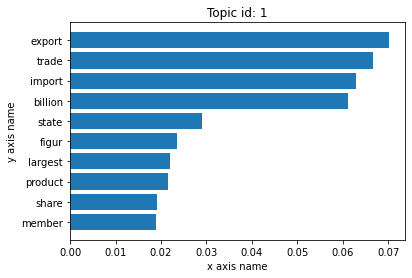


Topic id:  2
('statist', 0.05855983)
('european', 0.037975878)
('develop', 0.030287396)
('indic', 0.020396642)
('countri', 0.018424299)
('nation', 0.01807752)
('polici', 0.016343849)
('member', 0.012839845)
('eurostat', 0.012280554)
('state', 0.011622424)


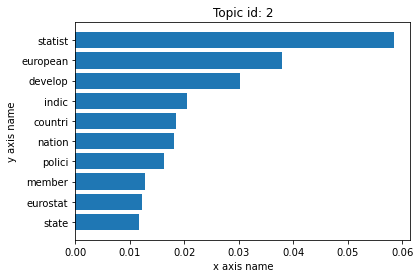


Topic id:  3
('servic', 0.052021045)
('account', 0.050414678)
('nation', 0.023804767)
('product', 0.021537403)
('compil', 0.012998099)
('econom', 0.011810008)
('suppli', 0.011773358)
('statist', 0.011678018)
('sourc', 0.010444146)
('includ', 0.010342402)


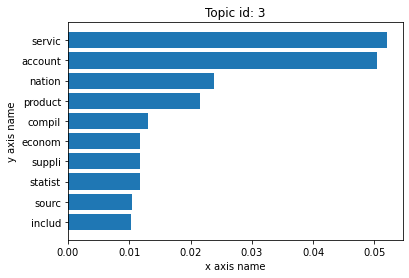


Topic id:  4
('survei', 0.034750134)
('statist', 0.03061871)
('inform', 0.021647723)
('collect', 0.020662665)
('regul', 0.018788718)
('countri', 0.017685857)
('classif', 0.015711715)
('refer', 0.015063882)
('activ', 0.0150149735)
('nation', 0.013759371)


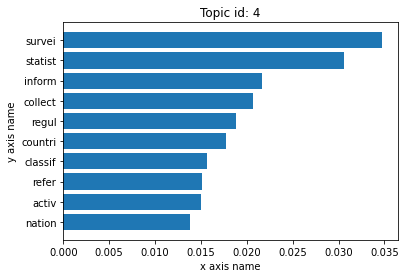


Topic id:  5
('region', 0.13013372)
('popul', 0.067118704)
('urban', 0.030547012)
('level', 0.02733224)
('project', 0.021026293)
('rural', 0.016827822)
('typolog', 0.014536329)
('chang', 0.013811229)
('commut', 0.013271912)
('inhabit', 0.01207284)


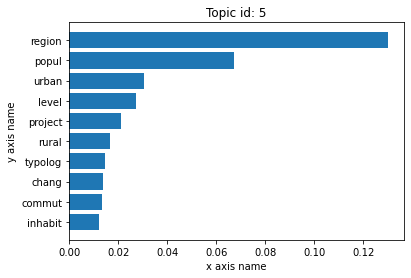


Topic id:  6
('energi', 0.09154233)
('product', 0.08998001)
('consumpt', 0.04660633)
('electr', 0.026377361)
('materi', 0.020439932)
('gener', 0.014920333)
('gross', 0.014561915)
('renew', 0.014200561)
('produc', 0.014046787)
('final', 0.013927386)


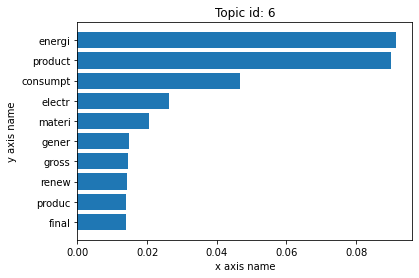


Topic id:  7
('citizen', 0.055208463)
('countri', 0.0413824)
('resid', 0.04085581)
('immigr', 0.037061036)
('permit', 0.034308363)
('gener', 0.027623443)
('member', 0.027312096)
('state', 0.027141858)
('number', 0.026509106)
('applic', 0.024181234)


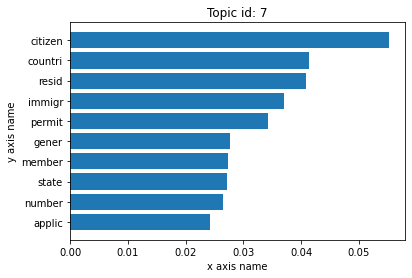


Topic id:  8
('transport', 0.04874227)
('accid', 0.028810704)
('increas', 0.028665174)
('emiss', 0.026422683)
('passeng', 0.019431725)
('fatal', 0.017084248)
('countri', 0.01673232)
('vehicl', 0.011913023)
('environment', 0.010754494)
('number', 0.010398479)


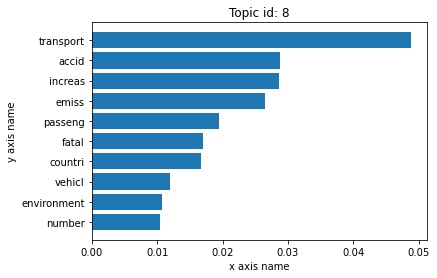


Topic id:  9
('peopl', 0.05367057)
('share', 0.026824353)
('young', 0.0240028)
('popul', 0.022094686)
('member', 0.020510986)
('state', 0.019952254)
('employ', 0.01913616)
('women', 0.01822713)
('point', 0.0177119)
('household', 0.01609132)


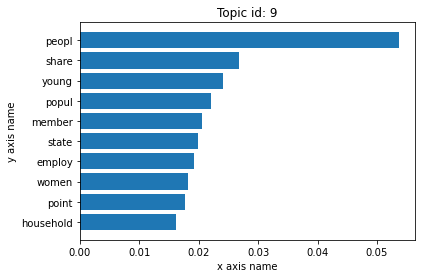


Topic id:  10
('train', 0.04832436)
('level', 0.042075835)
('languag', 0.027624533)
('formal', 0.025777847)
('skill', 0.024449155)
('learn', 0.021268327)
('particip', 0.020271216)
('group', 0.019841138)
('earli', 0.017300729)
('countri', 0.015352083)


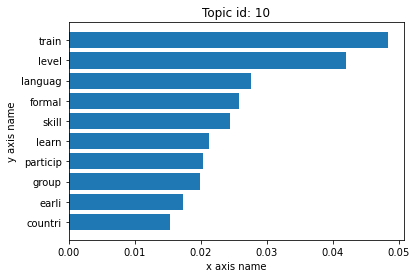


Topic id:  11
('agricultur', 0.05996445)
('product', 0.026535958)
('water', 0.025503617)
('common', 0.024520751)
('organ', 0.023588674)
('cover', 0.01823376)
('livestock', 0.017546523)
('manag', 0.016554095)
('includ', 0.013528149)
('hectar', 0.011936738)


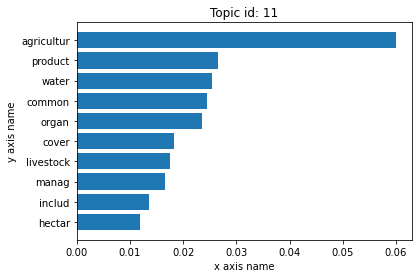


Topic id:  12
('state', 0.036234498)
('member', 0.03570925)
('increas', 0.034096677)
('countri', 0.02663628)
('share', 0.022373917)
('figur', 0.021695448)
('decreas', 0.020172738)
('total', 0.020039422)
('highest', 0.017900249)
('germani', 0.016699983)


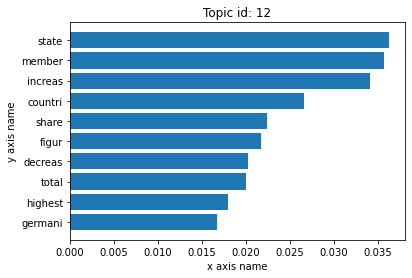


Topic id:  13
('enterpris', 0.06836844)
('activ', 0.050405033)
('emploi', 0.041201692)
('employ', 0.037324734)
('person', 0.03585317)
('sector', 0.028293831)
('employe', 0.025242688)
('servic', 0.023385819)
('labour', 0.020738313)
('economi', 0.02049887)


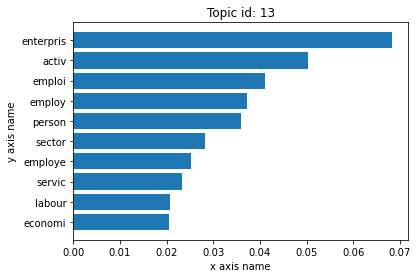


Topic id:  14
('financi', 0.04965211)
('govern', 0.041876085)
('expenditur', 0.038907167)
('invest', 0.02266843)
('asset', 0.021941809)
('social', 0.021625614)
('account', 0.019339513)
('liabil', 0.016601037)
('incom', 0.016035393)
('gross', 0.015412605)


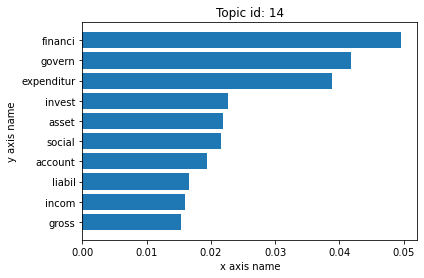


Topic id:  15
('price', 0.05565876)
('indic', 0.034641694)
('index', 0.02483618)
('chang', 0.02158588)
('estim', 0.017562993)
('annual', 0.017151298)
('period', 0.016542522)
('level', 0.016047196)
('industri', 0.014266072)
('countri', 0.014094408)


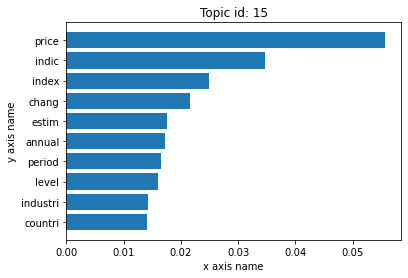


Topic id:  16
('household', 0.019477036)
('refer', 0.01931299)
('variabl', 0.01871539)
('popul', 0.017448582)
('indic', 0.017166598)
('calcul', 0.01715351)
('dimens', 0.01616758)
('inform', 0.01613304)
('statist', 0.015960077)
('person', 0.015902944)


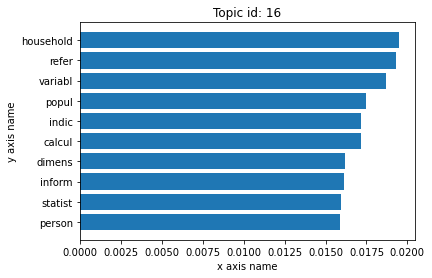


Topic id:  17
('health', 0.044287752)
('death', 0.03647196)
('popul', 0.022987202)
('state', 0.021125907)
('member', 0.02101358)
('women', 0.020890543)
('peopl', 0.019383514)
('report', 0.019073078)
('share', 0.017912658)
('inhabit', 0.017251048)


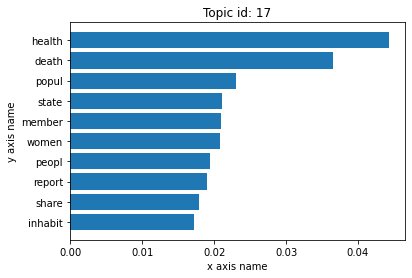


Topic id:  18
('member', 0.053558923)
('state', 0.038491745)
('share', 0.036004227)
('record', 0.027982341)
('cultur', 0.024347257)
('tertiari', 0.02080675)
('secondari', 0.019695662)
('ratio', 0.01867521)
('point', 0.016459327)
('level', 0.015867127)


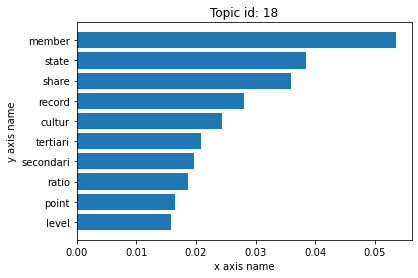


Topic id:  19
('incom', 0.079684995)
('household', 0.043535326)
('social', 0.038805764)
('poverti', 0.038756393)
('benefit', 0.029505659)
('candid', 0.024339044)
('countri', 0.023856655)
('pension', 0.02023281)
('expenditur', 0.019979492)
('dispos', 0.016733631)


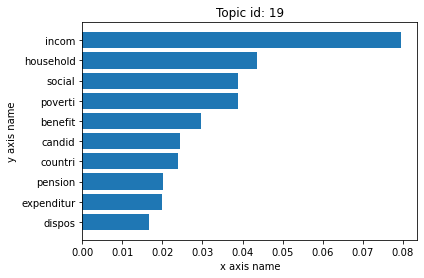


Topic id:  20
('tourism', 0.05823751)
('night', 0.05542859)
('spent', 0.054792188)
('tourist', 0.050534766)
('resid', 0.04578336)
('accommod', 0.042173482)
('countri', 0.029173208)
('number', 0.02763971)
('travel', 0.02479082)
('million', 0.022398543)


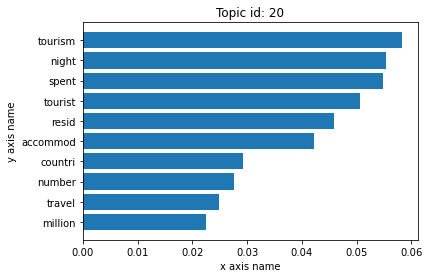

In [18]:

   
for topic_id in range(num_topics):
    print('\nTopic id: ',topic_id+1)
    top_words = [(a,b) for (a,b) in sorted(lda_model.show_topic(topic_id,topn=10),key=lambda x: x[1], reverse=True)]
    for t in range(len(top_words)):
        print(top_words[t])
    y_axis = [t[0] for t in top_words]
    x_axis = [t[1] for t in top_words] 
    
    plt.barh(y_axis,x_axis)
    plt.gca().invert_yaxis()
    plt.title('title name')
    plt.ylabel('y axis name')
    plt.xlabel('x axis name')
    plt.title('Topic id: '+str(topic_id+1))
    plt.show()        




### A tentative interpretation

We end-up with the following interpretations of the 20 topics. Together with the topic names, we also give the coherence scores by topic. We can see that topic 6 "Energy production and consumption has the highest coherence (0.66) while topic 8 "Transport accidents" has the lowest one (0.42).   


Topic  1. Coherence: 0.513099  EU exports to the world.  
Topic  2. Coherence: 0.605449  EU development indicators.  
Topic  3. Coherence: 0.584263  Good and services accounts.  
Topic  4. Coherence: 0.565895  Statistical surveys and methodologies.  
Topic  5. Coherence: 0.643886  Regions and population projections.  
Topic  6. Coherence: 0.660629  Energy production and consumption.  
Topic  7. Coherence: 0.501160  Refugees and asylum protection.  
Topic  8. Coherence: 0.425038  Transport accidents.  
Topic  9. Coherence: 0.486339  Employment of young people.  
Topic 10. Coherence: 0.604167  Skills, training and participation in society.  
Topic 11. Coherence: 0.649524  Agricultural production and resources.  
Topic 12. Coherence: 0.578583  Member States and their shares in the EU Economy.  
Topic 13. Coherence: 0.462794  Enterprise activities and employment.  
Topic 14. Coherence: 0.643560  Government financing, expenses, assets and liabilities.  
Topic 15. Coherence: 0.473877  Price 

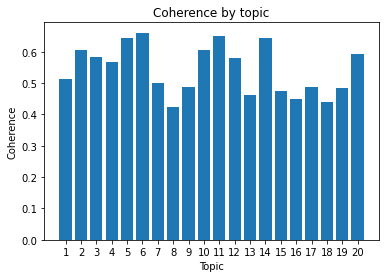

In [19]:
topic_names = [
'EU exports to the world',    
'EU development indicators',
'Good and services accounts',
'Statistical surveys and methodologies',
'Regions and population projections',
'Energy production and consumption',
'Refugees and asylum protection',
'Transport accidents',
'Employment of young people',
'Skills, training and participation in society',
'Agricultural production and resources',
'Member States and their shares in the EU Economy',
'Enterprise activities and employment',
'Government financing, expenses, assets and liabilities',
'Price indices and estimations',
'Household statistics',   
'Demography',
'Education statistics',
'Household disposable income, poverty and social benefits',
'Tourism statistics']

coh_topics = coherence_model_lda.get_coherence_per_topic(segmented_topics=None,with_std=False, with_support=False)

for (i,tn) in enumerate(topic_names):
    print('Topic {0:2d}. Coherence: {1:6f}  {2:s}.  '.format(i+1,coh_topics[i],tn))

fig, ax = plt.subplots()
x=np.arange(num_topics)+1
plt.bar(x=x,height=coh_topics)
plt.xlabel("Topic")
plt.ylabel("Coherence")
plt.title("Coherence by topic")
ax.set_xticks(x)
plt.show()
    

### Application of the LDA model to the OECD's Glossary articles

* Read the scraped content from OECD's Glossary.
* Carry out data cleansing.
* Collect all content in a column "raw content".


In [20]:
OECD_df = pd.read_excel('OECD_final_results_2.xlsx')
OECD_df['Term'] = OECD_df['Term'].apply(clean)
OECD_df['Definition:'] = OECD_df['Definition:'].apply(clean)
OECD_df['Context:'].fillna(value='',inplace=True)
OECD_df['Context:'] = OECD_df['Context:'].apply(clean)
OECD_df['raw content'] = OECD_df['Term'] +' '+OECD_df['Definition:'] +OECD_df['Context:'] 
OECD_df = OECD_df[['ID','URL','Term','raw content']]
print(OECD_df.isnull().sum())
OECD_df.dropna(subset=['ID','URL','Term','raw content'], inplace=True)
OECD_df.reset_index(drop=True,inplace=True)
print(OECD_df.isnull().sum())
OECD_df

ID             0
URL            0
Term           4
raw content    6
dtype: int64
ID             0
URL            0
Term           0
raw content    0
dtype: int64


,ID,URL,Term,raw content
0,1,https://stats.oecd.org/glossary/detail.asp?ID=1,Abatement,Abatement See Pollution abatement.
1,2,https://stats.oecd.org/glossary/detail.asp?ID=2,Absence from work due to illness,Absence from work due to illness Absence from ...
2,3,https://stats.oecd.org/glossary/detail.asp?ID=3,Activity restriction - free expectancy,Activity restriction - free expectancy Functio...
3,4,https://stats.oecd.org/glossary/detail.asp?ID=4,Acute care,Acute care Acute care is one in which the prin...
4,5,https://stats.oecd.org/glossary/detail.asp?ID=5,Acute care beds,Acute care beds Acute care beds are beds accom...
...,...,...,...,...
6928,7352,https://stats.oecd.org/glossary/detail.asp?ID=...,European Agricultural Fund for Rural Developme...,European Agricultural Fund for Rural Developme...
6929,7354,https://stats.oecd.org/glossary/detail.asp?ID=...,Carbon market,Carbon market A popular (but misleading) term ...
6930,7355,https://stats.oecd.org/glossary/detail.asp?ID=...,Classification structure,Classification structure Refers to how the cat...
6931,7356,https://stats.oecd.org/glossary/detail.asp?ID=...,United Nation Framework Convention on Climate ...,United Nation Framework Convention on Climate ...


### Create a "texts" list as before

In [21]:
texts = list(sent_to_words(OECD_df['raw content']))

### Create a new corpus based on OECD's Glossary entries

In [22]:
other_corpus = [id2word.doc2bow(text) for text in texts] 
print('\nTotal texts: ',len(other_corpus))


Total texts:  6933


### For each OECD article, find the closest topics and the corresponding probabilities
* We put a threshold of 0.3 for a topic to be reported. As a result, some articles do not have associated closest topics.
* Multiple topics and associated probabilities are separated by comma. 
* The results are sorted by descending maximum topic probability. 

### These results are for demonstration only. The actual labelling requires the production of: 

* A dataframe tm_values with the probabilities for each topic and term.
* A dataframe tm_topics linking tm_values with the topics information, with the topic id key.
* A dataframe tm_terms linking the tm_values with the terms information, with the term id key.
* A dataframe tm_articles with the probabilities of each topic, for each article. 

In [23]:
res = pd.DataFrame(range(len(other_corpus)),columns=['ID'])
for i in range(len(other_corpus)):
    
    #print('\n',i,OECD_df.loc[i,'term'])
    res.loc[i,'ID']=i
    res.loc[i,'Term']=OECD_df.loc[i,'Term']
    res.loc[i,'URL']=OECD_df.loc[i,'URL']
    unseen_doc = other_corpus[i]
    vector = lda_model[unseen_doc] 
    llist = sorted(lda_model.get_document_topics(unseen_doc),key=lambda x: x[1],reverse=True)
    rel_topics = ','.join(topic_names[k] for (k,p) in llist if p >= 0.3)
    rel_probs = ','.join(str(p) for (k,p) in llist if p >= 0.3)
    res.loc[i,'Topics']=rel_topics
    res.loc[i,'Probabilities']=rel_probs
    res.loc[i,'Max_probability']=max(p for (k,p) in llist)
res.sort_values(by='Max_probability',inplace=True,ascending=False,ignore_index=True)    
res    

,ID,Term,URL,Topics,Probabilities,Max_probability
0,208,Building – Eurostat,https://stats.oecd.org/glossary/detail.asp?ID=239,Household statistics,0.9895576,0.989558
1,6647,Number raised estimation,https://stats.oecd.org/glossary/detail.asp?ID=...,Household statistics,0.9824059,0.982406
2,5357,Implicit quality adjustment,https://stats.oecd.org/glossary/detail.asp?ID=...,Price indices and estimations,0.9779051,0.977905
3,1777,Output,https://stats.oecd.org/glossary/detail.asp?ID=...,Good and services accounts,0.9773791,0.977379
4,6282,Irregular component of a time series,https://stats.oecd.org/glossary/detail.asp?ID=...,Price indices and estimations,0.9743164,0.974316
...,...,...,...,...,...,...
6928,2894,Demonopolisation,https://stats.oecd.org/glossary/detail.asp?ID=...,,,0.050000
6929,5341,New goods,https://stats.oecd.org/glossary/detail.asp?ID=...,,,0.050000
6930,6763,Item list,https://stats.oecd.org/glossary/detail.asp?ID=...,,,0.050000
6931,4373,T-bills,https://stats.oecd.org/glossary/detail.asp?ID=...,,,0.050000


In [24]:
res.to_excel('tm_OECD.xlsx')